In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.transforms import Compose, ToTensor, Lambda, Pad
# from torchvision.datasets.mnist import MNIST
# from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import tqdm
import math
from utils2 import *

Files already downloaded and verified
Files already downloaded and verified
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Number of training images: 1000
torch.Size([46, 3, 32, 32])


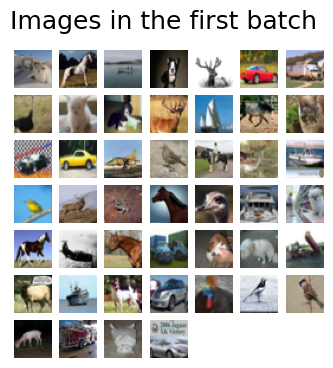

In [2]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

#from utils2 import *

batch_size = 46
num_classes = 10
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'



trainset, testset, classes = load_CIFAR10(num_classes)

trainset = getSubset(trainset, 100)

trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
# testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

print("Classes:", classes)
print("Number of training images:", len(trainset))
# print("Number of test images:", len(testset))
 
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx].transpose((1, 2, 0))) 
    fig.suptitle(title, fontsize=18)
    plt.show()

def show_first_batch(dataloader):
    for batch in dataloader:
        print(batch[0].shape)
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(trainloader)


In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 scale: int = 25):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size)
        self.input_mlp1 = PositionalEmbedding(emb_size, scale)
        self.input_mlp2 = PositionalEmbedding(emb_size, scale)

        concat_size = self.time_mlp.size + self.input_mlp1.size + self.input_mlp2.size
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size)).to(device)
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, mid_c = None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_c:
            mid_c = out_c
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size = 3, padding = 1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size = 3, padding = 1, bias=False),
            nn.GroupNorm(1, out_c)
        )
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c,out_c)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c)
        )
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1])
        return x + emb

class Up(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c,out_c,in_c//2)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c)
        )
    def forward(self, x, skip_x, t):
        x= self.up(x)
        x = torch.cat([skip_x,x],dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1])
        return x + emb

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels, self.size = channels, size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = x.view(-1, self.channels, self.size*self.size).swapaxes(1,2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln,x_ln,x_ln)
        attention_value = attention_value * x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2,1).view(-1, self.channels, self.size, self.size)

class UNet(nn.Module):
    def __init__(self, num_classes=10, time_dim=256):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.time_dim =  time_dim
        self.time_mlp = PositionalEmbedding(256, 1.0).to(self.device)
        self.encoder_input = DoubleConv(3, 64)
        self.encoder_downsample1 = Down(64,128)
        self.encoder_attention1 = SelfAttention(128,16)
        self.encoder_downsample2 = Down(128,256)
        self.encoder_attention2 = SelfAttention(256,8)
        self.encoder_downsample3 = Down(256, 256)
        self.encoder_attention3 = SelfAttention(256, 4)

        self.conv1 = DoubleConv(256,512)
        self.conv2 = DoubleConv(512,512)
        self.conv3 = DoubleConv(512,256)

        self.decoder_upsample1 = Up(512, 128)
        self.decoder_attention1 = SelfAttention(128, 8)
        self.decoder_upsample2 = Up(256, 64)
        self.decoder_attention2 = SelfAttention(64, 16)
        self.decoder_upsample3 = Up(128, 64)
        self.decoder_attention3 = SelfAttention(64, 32)
        self.decoder_output = nn.Conv2d(64, 3, kernel_size = 1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t,y=None):
        t = self.time_mlp(t)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.encoder_input(x)
        x2 = self.encoder_downsample1(x1,t)
        x2 = self.encoder_attention1(x2)
        x3 = self.encoder_downsample2(x2, t)
        x3 = self.encoder_attention2(x3)
        x4 = self.encoder_downsample3(x3, t)
        x4 = self.encoder_attention3(x4)

        x4 = self.conv1(x4)
        x4 = self.conv2(x4)
        x4 = self.conv3(x4)

        x3 = self.decoder_upsample1(x4, x3, t)
        x3 = self.decoder_attention1(x3)
        x2 = self.decoder_upsample2(x3, x2, t)
        x2 = self.decoder_attention2(x2)
        x1 = self.decoder_upsample3(x2, x1, t)
        x = self.decoder_attention3(x1)
        return self.decoder_output(x)


#### 3. Construct Conditional Denoising Diffusion Probabilistic Model (cddpm)

Copy the previous defined ddpm here (some modification is needed).

Make necessary changes:
1. change the num_timesteps to 1000 because now we are generating more complicated images.
2. put self.betas to GPU by `.to(self.device)`.
3. Previously we expand the dimension of the parameters to be the same as the input data by `[:,None]`, now you have to do `[:,None,None,None]` instead.

In [5]:
class cddpm():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule='linear'
                 ):
        # Initialize parameters
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_timesteps =num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_schedule = beta_schedule

        # Initialize noise scheduler betas
        # this parameter should have a dimension of [num_timesteps]
        self.betas = self.noiseScheduler()
        self.betas = self.betas.to(self.device)

        # parameters alpha, alphas_cumprod, alphas_cumprod_prev
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        # alphas_cumprod is the comulatetive product of alphas: $\bar{\alpha}_{t}$
        # alphas_cumprod_prev stores a shifted version of alphas_cumprod: $\bar{\alpha}_{t-1}$
        # for alphas_cumprod_prev don't forget to pad 1. for the first element
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        ones = torch.ones(num_timesteps)
        ones[1:num_timesteps] = self.alphas_cumprod[0:num_timesteps-1]
        
        self.alphas_cumprod_prev = ones
        self.alphas_cumprod_prev = self.alphas_cumprod_prev.to(device)
        #print(self.alphas_cumprod, "cumprod")
        #print(self.alphas_cumprod_prev, "cumprod prev")

        # compute parameters required for function self.add_noise
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1-self.alphas_cumprod)

        # compute parameters required for function self.q_posterior
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.posterior_mean_coef1 = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod) 
        self.posterior_mean_coef2 = torch.sqrt(self.alphas) * (1- self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) 

        # compute parameters required for function self.reconstruct_x0
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.reconstruct_x0_coef1 = (1/self.sqrt_alphas_cumprod)
        self.reconstruct_x0_coef2 = (1/self.sqrt_alphas_cumprod) * self.sqrt_one_minus_alphas_cumprod

        # expand dimension
        # Each of this parameters should have dimension of [num_timesteps,1]
        # This is for the following operation so that we don't get a mismatch of dimensions
        self.alphas = self.alphas[:,None,None,None]
        self.alphas_cumprod = self.alphas_cumprod[:,None,None,None]
        self.alphas_cumprod_prev = self.alphas_cumprod_prev[:,None,None,None]
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod[:,None,None,None]
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod[:,None,None,None]
        self.posterior_mean_coef1 = self.posterior_mean_coef1[:,None,None,None]
        self.posterior_mean_coef2 = self.posterior_mean_coef2[:,None,None,None]
        self.reconstruct_x0_coef1 = self.reconstruct_x0_coef1[:,None,None,None]
        self.reconstruct_x0_coef2 = self.reconstruct_x0_coef2[:,None,None,None]

    # construct noise beta scheduler
    # you are supposed to construct a linear beta scheduler
    # input: number of time steps
    # output: a variable called 'betas' that has a dimension of [num_timesteps]
    # hint: use torch.linspace to construct the one-dimensional tensor beta
    def noiseScheduler(self):
        betas = torch.linspace(self.beta_start, self.beta_end, self.num_timesteps)
        return betas

    # forward process $q(x_{t}|x_{0})$
    # inputs: x_0(input data), noise(random sampled noise), and t(random sampled timestep)
    # output: x_t(noisy data)
    # dimensions:
    # x_0: [batch_size, 1]
    # noise: [batch_size, 1]
    # t: [batch_size]
    # x_t: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.

    #s19
    def add_noise(self, x_0, noise, t):
        s1 = self.sqrt_alphas_cumprod[t]
        #s1.to(device)
        s2 = self.sqrt_one_minus_alphas_cumprod[t]
        #s2.to(device)
        return s1 * x_0 + s2 * noise       ########ändra här
        #return noise.device * x_0 + s2.to(noise.device) * noise

    # forward process posteriors mean $q(x_{t-1}|x_{t},x_{0})$
    # input: x_0(reconstructed input data), x_t(noisy data from forward process), and t(current timestep)
    # output: mu(posteriors mean)
    # dimensions:
    # x_0: [batch_size, 1]
    # x_t: [batch_size, 1]
    # t: scalar
    # mu: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        mu = s1 * x_0 + s2 * x_t
        return mu

    # forward process posteriors variance $q(x_{t-1}|x_{t},x_{0})$
    # input: t(current timestep)
    # output: variance(posteriors variance)
    # dimensions:
    # t: scalar
    # variance: scalar
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def get_variance(self, t):
        variance =   ( (1 - self.alphas_cumprod_prev[t]) /(1-self.alphas_cumprod[t])  )* self.betas[t]
        return variance

    # reconstruct input data x_0 according to forward process equation
    # input: x_t(noisy data from forward process), t(current timestep), and pred_noise(predicted noise from model output)
    # output: x_0(reconstructed input data)
    # dimensions:
    # x_t: [batch_size, 1]
    # t: scalar
    # pred_noise: [batch_size, 1]
    # x_0: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def reconstruct_x0(self, x_t, t, pred_noise):
        s1 = self.reconstruct_x0_coef1[t]
        s2 = self.reconstruct_x0_coef2[t]
        return s1 * x_t - s2 * pred_noise

    # sample timesteps for training
    # input: n(batch size)
    # output: randomly sampled integers
    # dimensions:
    # n: scalar
    # output: [batch_size]
    # hint: use torch.randint to select random integers for training
    def sample_timesteps(self, n):
        t = torch.randint(low = 1, high = self.num_timesteps, size=(n,))
        return t

    # one step backward during sampling(inference)
    # functions needed: reconstruct_x0, q_posterior, and
    # input: pred_noise(predicted noise from model output), t(current time step), sample(sample from the last step)
    # output: prev_sample
    # dimensions:
    # pred_noise: [batch_size, 1]
    # t: scalar
    # sample: [batch_size, 1]
    # prev_sample: [batch_size, 1] (input to the next loop)
    # hint:
    # 1. resconstruct x_0 from x_t, t, and pred_noise
    # 2. predict the mean of the previous sample, i.e. x_{t-1} by function 'q_posterior'. This function takes the reconstructed x_0, x_t, t as input.
    # 3. predict the variance of the previous sample by function 'get_variance'.
    # 4. Don't forget to set variance to 0 when t==1, which is the last output, and we don't want any noise here.
    def step(self, pred_noise, t, x_t):
        # sample Gaussian noise
        # the noise shoule have the same shape as 'pred_noise'
        #noise = torch.normal(mean=0, std=torch.eye(pred_noise.shape[1]))
        noise = torch.randn_like(pred_noise)
        #print(noise.shape)
        #print(pred_noise.shape)
        # reconstruct x_0
        pred_x_0 = self.reconstruct_x0(x_t, t, pred_noise)
        # compute posterior mean
        mean = self.q_posterior(pred_x_0, x_t, t)
        # compute posterior variance (different if t == 0 or if t > 0!)
        if t == 0:
            variance = 0
        if t > 0:
            variance = self.get_variance(t)
        # sample based on posterior and variance
        pred_prev_sample = mean + (variance ** 0.5) * noise

        return pred_prev_sample

#### 4. Training and Sampling



Training model...


Epoch 0: 100%|██████████| 22/22 [01:18<00:00,  3.58s/it]
999it [03:39,  4.56it/s]


torch.Size([20, 3, 32, 32]) sample shape


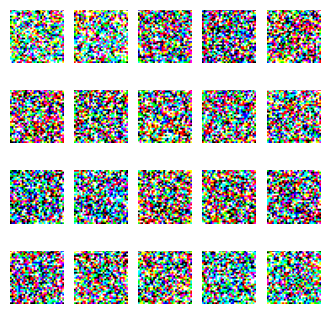

Epoch 50: 100%|██████████| 22/22 [01:08<00:00,  3.13s/it]
999it [04:59,  3.33it/s]


torch.Size([20, 3, 32, 32]) sample shape


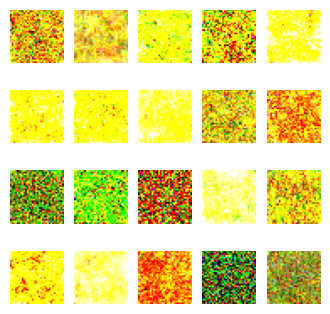

Epoch 99: 100%|██████████| 22/22 [01:15<00:00,  3.43s/it]
999it [04:55,  3.38it/s]


torch.Size([20, 3, 32, 32]) sample shape


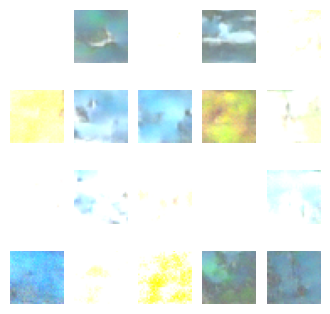

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define Model and put the model to GPU
model = UNet()
model = model.to(device)

# Initialize Denoising Diffusion Model
diffusion = cddpm()
# Initialize Optimizer
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

save_images_step = 50
num_epochs = 100
eval_batch_size = 20
img_size = 32 # 32 works better for the UNET
print("Training model...")

# Train
for epoch in range(num_epochs):
    model.train()
    lbar = tqdm.tqdm(trainloader)
    lbar.set_description(f"Epoch {epoch}")
    for i, (images, classes) in enumerate(lbar):
        images, classes = images.to(device), classes.to(device)
        # randomly sample 'noise' that has the same dimension as 'images'
        # hint: you may want to use function 'torch.randn_like'
        noise = torch.randn_like(images)
        # noise.to(device)
        # randomly sample timesteps 't' for each image in the batch
        # hint: you may want to use the function 'sample_timesteps' we defined in class cddpm
        # hint: use .shape[0] to get the batch size
        # don't forget to put timesteps 't on GPU
        t = diffusion.sample_timesteps(n=images.shape[0])
        t = t.to(device)
        # add noise to the clean image according to the timesteps 't' we sampled
        # hint: you may want to use the function 'add_noise' we defined in class cddpm
        # print(images.shape, "images shape")
        # print(noise.shape, "noise shape")
        x_t = diffusion.add_noise(images, noise, t)
        # predict the noise based on the noise image, the timestep, and the labels by the Unet we defined
        # print(classes, "classes")
        predicted_noise = model(x_t, t, classes)
        # compute a loss between the randomly sampled noise and the predicted noise
        # hint: you may want to use function F.mse_loss
        loss = F.mse_loss(predicted_noise, noise)
        # complete the rest by .backward(), .step(), .zero_grad()
        ###################
        #  add your code  #
        ###################
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    lbar.close()

    # Sampling
    if epoch % save_images_step == 0 or epoch == num_epochs - 1:
        model.eval()
        classes = torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]).to(device)
        with torch.no_grad():
            # randomly sample 'noise' that has the dimension [eval_batch_size, 1, img_size, img_size]
            # this will be the starting point of our sampling i.e. x_T
            # don't forget to put this on the GPU
            sample = torch.randn((eval_batch_size, 3, img_size, img_size)).to(device)
            for i in tqdm.tqdm(reversed(range(1, diffusion.num_timesteps)), position= 0):
                t = (torch.ones(eval_batch_size) * i).long().to(device)
                # predict the noise based on the current noise image, the timestep, and the labels by the Unet we defined
                # hint: to predict the noise, the timestep shoule be the same dimension as the input batch, think about whether to use 't' or 'i' here
                # print("Shapes:")
                # print("sample:", sample.shape)
                # print("t:", t.shape)
                # print("classes:", classes.shape)
                predicted_noise = model(sample, t, classes)
                # given the predicted noise and the current timestep and the current noise image, we are able to step one timestep backward
                # hint: you may want to use the function 'step' we defined in class cddpm
                # hint: the timestep in function 'step' shoule be a scalar, think about whether to use 't' or 'i' here
                sample = diffusion.step(predicted_noise, i, sample)
            sample = (sample.clamp(-1,1) + 1)/2
            print(sample.shape, "sample shape")
            # sample = sample.cpu().detach().numpy()  # Move to CPU and convert to NumPy array
            show_images(sample)

In [9]:
torch.save(model.state_dict, 'diffusion_100epoch.pt')

In [ ]:
model = UNet()
model.load_state_dict(torch.load('diffusion_100epoch.pt'))